In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import time
import ignite
import numpy as np
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from typing import List, Callable
import pickle
import tqdm
import pytorch_lightning as pl
import torchmetrics
import os.path
import cv2
import csv
import pandas as pd
#from google.colab import drive
from google.colab.patches import cv2_imshow
import fnmatch
from math import sqrt
from PIL import Image
import joblib
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import Callback

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.8.1+cu101


## Parameters

In [4]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
WD = 1e-4

## Data Classes

In [8]:
# Modificamos la carpeta 
print(os.getcwd())
print(os.listdir("Pruebas ImitAI"))
os.chdir("Pruebas ImitAI/1000 datos")
#os.chdir("../Prueba")
os.listdir()

/home/hodei.zia/ImitAI Project
['450 datos + Joint_velocities', 'Test_dataset', 'Train_dataset', 'lightning_logs', 'model_pytorch', 'model_pytorch_positions_015', 'Prueba', '400 datos + 10 Imagenes', '400 datos + 8 imagenes Depth + Joint_velocities', '400 datos + 8 imagenes Overhead + Joint_velocities', '400 datos + 6 imagenes + Joint_velocities', '400 datos + 10 Imagenes Bien', '1000 datos', '1000 Images New Dataset']


['Test_dataset',
 'Train_dataset',
 'MinMax_scaler.save',
 'lightning_logs',
 'model_pytorch_019',
 'MinMax_scaler_019.save',
 'model_pytorch_0124_notnorm',
 'model_pytorch_01848',
 'MinMax_scaler_4Images.save',
 'MinMax_scaler_no.save',
 'model_pytorch_00930',
 'model_pytorch_00927',
 'model_pytorch_00910']

In [6]:
def red_merge(carpeta_imagenes):
    
    length = len(fnmatch.filter(os.listdir(carpeta_imagenes + "Front_rgb/"), '*.png'))
    path = carpeta_imagenes + "Front_rgb/0.png"
    img = cv2.imread(path,1)
    aux = np.zeros(np.shape(img))
    
    for idx in range(length):
        path = carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"

        #blurring and smoothin
        img=cv2.imread(path,1)

        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        lower_red = np.array([0,50,50])
        upper_red = np.array([10,255,255])

        mask = cv2.inRange(hsv, lower_red, upper_red)
        res = cv2.bitwise_and(img,img, mask= mask)

        aux = aux + res
    return aux
'''
res = red_merge("Train_dataset/")
cv2_imshow(res)'''

'\nres = red_merge("Train_dataset/")\ncv2_imshow(res)'

In [7]:
os.getcwd()

'/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos'

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos


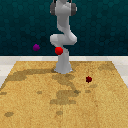

CPU times: user 223 ms, sys: 45 ms, total: 268 ms
Wall time: 535 ms


In [8]:
%%time
print(os.getcwd())
for i in range(1000):
    im = Image.open("Test_dataset/Front_rgb/"+str(i)+".png")
display(im)

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos


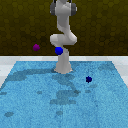

CPU times: user 598 ms, sys: 75.1 ms, total: 673 ms
Wall time: 686 ms


In [9]:
%%time
print(os.getcwd())
for i in range(1000):
    image = cv2.imread("Test_dataset/Front_rgb/"+str(i)+".png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image)

### Normalizamos las acciones

In [11]:
print(os.getcwd())
print(os.listdir())
with open('Train_dataset/Train_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Train_dataset/Train_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

with open('Test_dataset/Test_Actions.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    x = np.loadtxt(lines, delimiter=',', skiprows=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x_transformed = scaler.transform(x)
np.savetxt('Test_dataset/Test_Actions_Normalized.csv',x_transformed , delimiter=',', header="X1,X2,X3,X4,X5,X6,X7")

/home/hodei.zia/ImitAI Project/Pruebas ImitAI/1000 datos
['Test_dataset', 'Train_dataset', 'MinMax_scaler.save', 'lightning_logs', 'model_pytorch_019', 'MinMax_scaler_019.save', 'model_pytorch_0124_notnorm', 'model_pytorch_01848', 'MinMax_scaler_4Images.save', 'MinMax_scaler_no.save', 'model_pytorch_00930', 'model_pytorch_00927', 'model_pytorch_00910']


In [12]:
x_transformed.min(axis=0)

array([-1., -1., -1., -1., -1., -1., -1.])

In [13]:
scaler_filename = "MinMax_scaler.save"
scaler_to_save = MinMaxScaler(feature_range=(-1, 1))
joblib.dump(scaler_to_save, scaler_filename) 
scaler = joblib.load(scaler_filename) 

In [9]:
# Clases para mas de una imagen

class ObsActionGetter(object):
    """
    Generic class that return the image and the action given an index
    """
    def __init__(self, carpeta_imagenes, archivo_acciones):
        # TODO: get a list of all image files
        self.archivo_acciones = archivo_acciones
        self.carpeta_imagenes = carpeta_imagenes
        path, dirs, files = next(os.walk(self.carpeta_imagenes))
        self.image_files = list(range(len(files)))
        # TODO: get all made actions
        self.actions = []
        
    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.carpeta_imagenes + "Front_rgb/"), '*.png'))
        
    def __getitem__(self, idx):
        path_1 = self.carpeta_imagenes + "Front_rgb/" + str(idx) + ".png"
        im1 = np.array(Image.open(path_1)) 
        
        # TODO: get the action
        data = pd.read_csv(self.archivo_acciones, header = 0)
        action = np.float32(np.array(data.iloc[idx]))
        if (idx == 0):
            action_prev = np.array([0,0,0,0,0,0,0], dtype="float32")
        else:
            action_prev = np.float32(np.array(data.iloc[idx-1]))
        
        # Return both image and action
        return im1, action, action_prev

class ObsActionDataset(Dataset):
    """
    PyTorch Dataset for getting the data. In this case, from ObsActionGetter object
    """
    def __init__(self, obs_action_getter: ObsActionGetter, transformations: List[Callable]):
        super(ObsActionDataset, self).__init__()
        self.obs_action_getter = obs_action_getter
        self.transformations = transformations
        
    def __len__(self):
        return len(self.obs_action_getter)
    
    def __getitem__(self, idx):
        im1, action, action_prev = self.obs_action_getter[idx]
        for t in self.transformations:
            im1 = t(im1)
        # Return both image and action
        return (im1, action_prev), action
    
class MultiImage(nn.Module):
    def __init__(self, fe, clf):
        super(MultiImage, self).__init__()
        self.fe = fe
        self.clf = clf
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
    def forward(self, x):
        x1, x2 = x
        f1 = self.fe(x1)
        f = self.flatten(self.avg_pool(f1))
        f = torch.cat((f, x2), dim=1)
        return self.clf(f)

In [10]:
print(len(fnmatch.filter(os.listdir('Test_dataset/Front_rgb'), '*.png')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Test_dataset/Overhead_rgb'), '*')))
#print(len(fnmatch.filter(os.listdir('Test_dataset/Overhead_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Front_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Right_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Left_rgb'), '*')))
print(len(fnmatch.filter(os.listdir('Train_dataset/Overhead_rgb'), '*')))
#print(len(fnmatch.filter(os.listdir('Train_dataset/Overhead_rgb'), '*')))

9036
9036
9036
9036
35408
35408
35408
35408


In [11]:
# Para mas de una imagen

# Create train Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

train_obs_action_getter = ObsActionGetter('Train_dataset/', 'Train_dataset/Train_Actions_Normalized.csv')
train_dataset = ObsActionDataset(train_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

# Create test Dataset.
# The ToTensor transform converts the image to Tensor in [0, 1] range and makes it channel first
# The Normalize transform normalizes the tensor using Imagenet stats

test_obs_action_getter = ObsActionGetter('Test_dataset/', 'Test_dataset/Test_Actions_Normalized.csv')
test_dataset = ObsActionDataset(test_obs_action_getter, 
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

In [12]:
%%time
# Create loaders (class that groups examples in batches)
# Uriz: train DataLoader should have shuffle to True
# Uriz: test DataLoader should have drop_last to False
# Uriz: use more workers to improve the training speed (load data in sever CPU threads). Otherwise we have a CPU -> GPU bottleneck
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=16)

print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))
'''
print("\nAccion Previa:", train_obs_action_getter[0][1])
print("\nAccion Actual:", train_obs_action_getter[0][0])
print("\nAccion Previa del siguiente:", train_obs_action_getter[1][1],"\n\n")
print(train_dataset[1][0][0])'''

35408
1106
9036
283
CPU times: user 87.7 ms, sys: 49.1 ms, total: 137 ms
Wall time: 135 ms


'\nprint("\nAccion Previa:", train_obs_action_getter[0][1])\nprint("\nAccion Actual:", train_obs_action_getter[0][0])\nprint("\nAccion Previa del siguiente:", train_obs_action_getter[1][1],"\n\n")\nprint(train_dataset[1][0][0])'

In [13]:
it = iter(test_loader)
first = next(it)
second = next(it)
print(it)


## Model

We use a pretrained ResNet18 for now. We have to remove the classifier head because it is traiend for classification with 1000 classes. We add a custom head to make regression of 7 values

In [14]:
# To pretrain
model = models.resnet18(pretrained=True)

# Get only the feature extractor (remove avgpool and fc layers)
fe = nn.Sequential(*list(model.children())[:-2])

def freeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(False)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(False)
            
def unfreeze_all_but_bn(m):
    """
    Function that set a module as no trainable (not required grad) only if it is not a BatchNorm module
    Args:
        m: PyTorch Module
    """
    if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.requires_grad_(True)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.requires_grad_(True)
            
# Freeze all but BatchNorm layers of feature extractor
# Uriz: if we use the "normal" ResNet use the pretained version and freeze all but BN
#       only set all trainiable when we change the fitst convolution layer to accept images of 6 dimensions
#       if the ResNet is pretrained and freezed the training accuracy is maintained (or increased) and the train time is dreceased
fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

# Create custom head
head_clf = nn.Sequential(
    nn.BatchNorm1d(512+7),
    nn.Dropout(0.25),
    nn.Linear(512+7, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),   
    nn.Dropout(0.25),
    nn.Linear(512, 7)
)

# Rebuild the model
model = MultiImage(fe, head_clf)

## Train Model

In [15]:
# Create trainable class with Pytorch Lightinng
class LitModel(pl.LightningModule):
    def __init__(self, model, loss_function, total_iterations, lr):
        """
        Constructor of the trainable class
        Args:
            model: PyTorch model
            loss_function: The loss function to use
            total_iterations: The total number of iterations for training (num_batches * num_epochs). Used for
                                LR Schedule
            lr: the max_lr to use for the OneCycleLR policy
        """
        super().__init__()
        # Store params
        self.model = model
        self.loss_function = loss_function
        self.total_iterations = total_iterations
        self.lr = lr
        # For measure the MSE
        self.train_mse = torchmetrics.MeanSquaredError()
        self.valid_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        # Forward method
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.train_mse(prediction, y)
        # Log loss and MSE
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=True, on_epoch=False, prog_bar=True)
        #print("MSE:",self.train_mse(prediction, y))
        #for i in range(7):
        #    plt.plot(prediction.cpu().detach().numpy()[:,i], label='prediction')
        #    plt.plot(y.cpu().detach().numpy()[:,i], label='target')
        #    plt.show()
        # Return Loss for backward
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_mse.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_function(prediction, y)
        # Get MSE
        self.valid_mse(prediction, y)
        # Log loss and MSE
        self.log('valid_loss', loss, prog_bar=True)
        self.log('val_mse', self.valid_mse, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.valid_mse.compute())

    def configure_optimizers(self):
        # Get Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Set OneCycleLR policy
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr,
                                                             total_steps=self.total_iterations),
            'interval': 'step', 'frequency': 1, 'name': 'lr_logger'
        }
        return [optimizer], [lr_scheduler]

In [16]:
class CallbackClass(Callback):
    def __init__(self, what="epochs", verbose=True):
        self.what = what
        self.verbose = verbose
        self.state = {"epochs": 0}
        
    @property
    def state_key(self):
        # note: we do not include `verbose` here on purpose
        return self._generate_state_key(what=self.what)

    def on_train_epoch_end(self, *args, **kwargs):
        e = 0
        if self.what == "epochs":
            self.state["epochs"] += 1
            
        if self.state["epochs"] == 2:
            for param in pl_model.parameters():
                param.requires_grad = True # Unfreeze
        
        for name, param in pl_model.named_parameters():
            if param.requires_grad:
                e = e+1

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)

    def state_dict(self):
        return self.state.copy()

## Find the best LR and Train the Model

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.63E-03


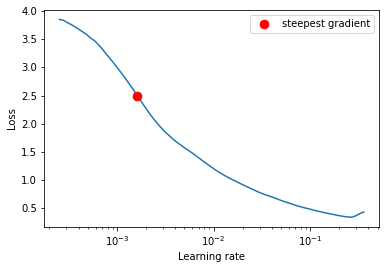

0.0016297508346206442
0.0016


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



0.0016
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_251560/2549930227.py", line 29, in <module>
    log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs", num_epoch=EPOCHS)])
TypeError: __init__() got an unexpected keyword argument 'num_epoch'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IP

--- Logging error ---
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_251560/2549930227.py", line 29, in <module>
    log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs", num_epoch=EPOCHS)])
TypeError: __init__() got an unexpected keyword argument 'num_epoch'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/s

In [ ]:
# Loss function
criterion = nn.MSELoss()

# We catch the optimizer of our lit_model
# optimizer, lr_scheduler = pl_model.configure_optimizers()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Learning State Finder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

# Create trainer class
try:
    print(lr_finder.plot()[1])
except:
    print("AxisPlot Error")

BEST_LR = float(input())
print(BEST_LR)

# Number of iterations for LR Schedule
ITERATIONS_PER_EPOCH = len(train_loader)

# Create PytorchLighting model for training
pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * EPOCHS, lr=BEST_LR)

NUM_GPUS = 1 if torch.cuda.is_available() else 0
trainer = pl.Trainer(auto_lr_find=True, min_epochs=EPOCHS, max_epochs=EPOCHS,
                     log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")])

# Train the model
trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)

## Make Predictions and Save the Model

In [220]:
# Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
model = model.eval()
# Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# To concatenate predictions and labels
predictions = None
labels = None
# Surround all for not computing gradients
with torch.no_grad():
    # Iterate over test dataset
    for x, y in tqdm.notebook.tqdm(test_loader):
        # Move to device
        x1, x2 = x
        x1 = x1.to(device)
        x2 = x2.to(device)
        # Predict
        o = model((x1, x2))
        # Concatenate
        if predictions is None:
            predictions = o
        else:
            predictions = torch.cat((predictions, o), axis=0)

        if labels is None:
            labels = y
        else:
            labels = torch.cat((labels, y), axis=0)
    
    # Move predictions to CPU and to numpy
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

mse = sklearn.metrics.mean_squared_error(labels, predictions)
rmse = sqrt(mse)
print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
print("El valor RMSE es igual a " + str(rmse))

ERROR! Session/line number was not unique in database. History logging moved to new session 318


  0%|          | 0/281 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 85880490.0
El valor RMSE es igual a 9267.172600097616


In [153]:
# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print(joint_error)

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")

[0.09194594 0.10613227 0.06660699 0.06533385 0.15250742 0.07293987
 0.09798293]
Articulacion 0 [-1.0 - 1.0] 2.0 4.6%
Articulacion 1 [-1.0 - 1.0] 2.0 5.31%
Articulacion 2 [-1.0 - 1.0] 2.0 3.33%
Articulacion 3 [-1.0 - 1.0] 2.0 3.27%
Articulacion 4 [-1.0 - 1.0] 2.0 7.63%
Articulacion 5 [-1.0 - 1.0] 2.0 3.65%
Articulacion 6 [-1.0 - 1.0] 2.0 4.9%


ERROR! Session/line number was not unique in database. History logging moved to new session 296


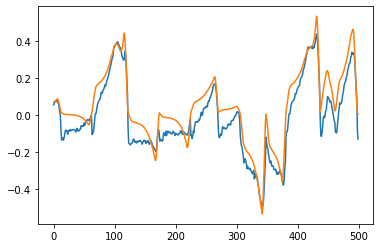

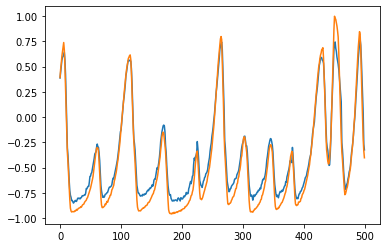

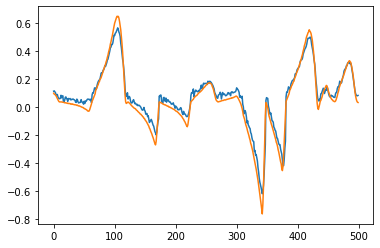

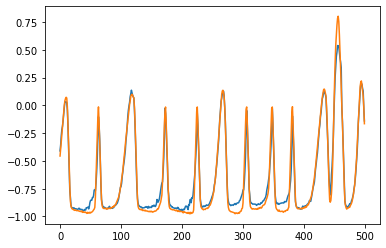

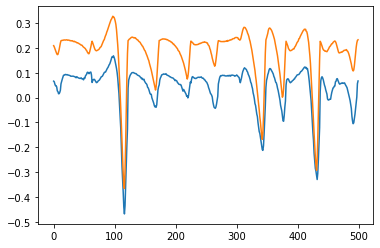

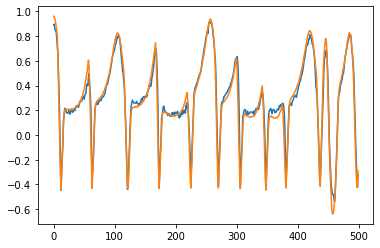

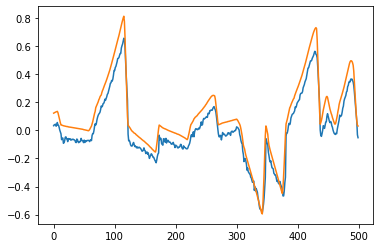

In [155]:
import matplotlib.pyplot as plt

for i in range(7):
    plt.plot(predictions[500:1000, i], label='prediction')
    plt.plot(labels[500:1000, i], label='target')
    plt.show()

## Bucle to obtain all the info for differents Epochs

In [17]:
RMSE_List = []
Model_List = []
Prediction_List = []
Label_List = []
LR_List = []
Loss_List = []

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-03


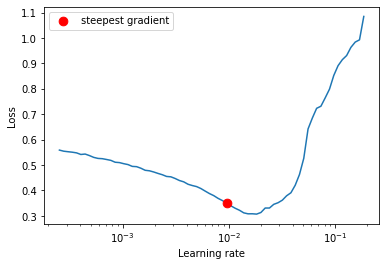

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.009545484566618342
EPOCH NUMERO: 1


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.028322142
El valor RMSE es igual a 0.1682918346727985
[0.1682918346727985]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


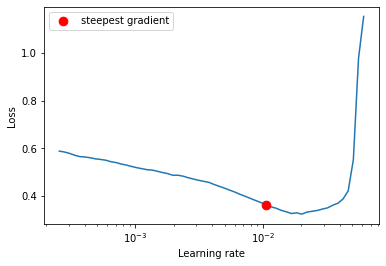

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.010476157527896652
EPOCH NUMERO: 2


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.16281222
El valor RMSE es igual a 0.4034999604337406
[0.1682918346727985, 0.4034999604337406]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.77E-02


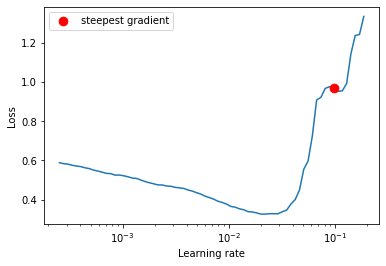

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.09770099572992257
EPOCH NUMERO: 3


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.13950579
El valor RMSE es igual a 0.37350473716392313
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.22E-03


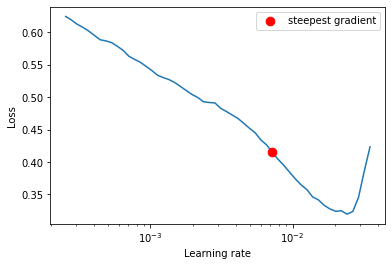

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.007220809018385464
EPOCH NUMERO: 4


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.05068161
El valor RMSE es igual a 0.22512576409728638
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-03


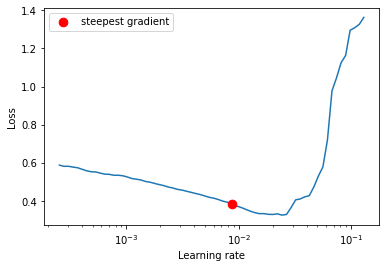

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.008697490026177835
EPOCH NUMERO: 5


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.016640062
El valor RMSE es igual a 0.1289963624006098
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-01


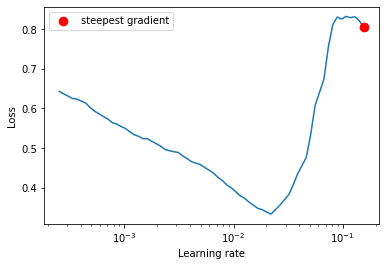

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.15556761439304725
EPOCH NUMERO: 6


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 6.7877975
El valor RMSE es igual a 2.6053401795196125
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


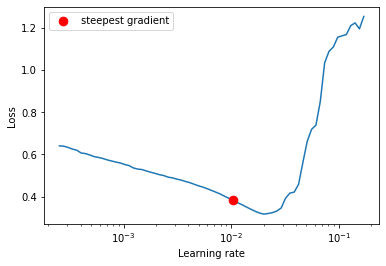

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.010476157527896652
EPOCH NUMERO: 7


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.045009345
El valor RMSE es igual a 0.21215405915562371
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-01


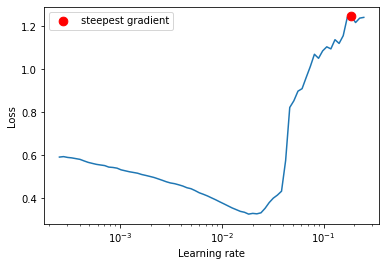

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.18738174228603852
EPOCH NUMERO: 8


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 2548.8792
El valor RMSE es igual a 50.486425407139144
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-01


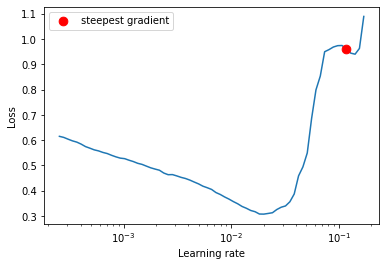

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.11768119524349979
EPOCH NUMERO: 9


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.016816454
El valor RMSE es igual a 0.12967827114910818
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


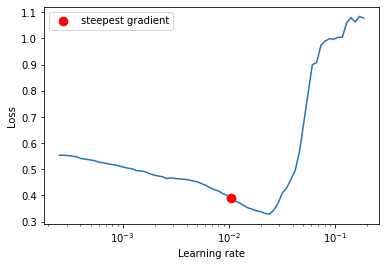

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.010476157527896652
EPOCH NUMERO: 10


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.017041152
El valor RMSE es igual a 0.13054176474658963
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818, 0.13054176474658963]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-03


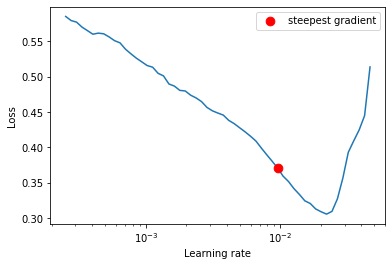

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.009545484566618342
EPOCH NUMERO: 11


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.015110356
El valor RMSE es igual a 0.12292418721260824
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818, 0.13054176474658963, 0.12292418721260824]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.92E-03


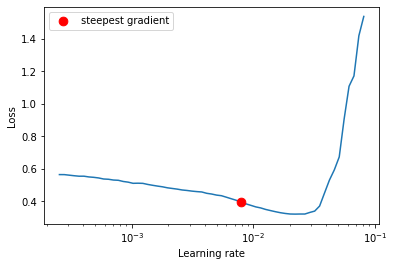

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.007924828983539174
EPOCH NUMERO: 12


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.015201057
El valor RMSE es igual a 0.12329256793262991
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818, 0.13054176474658963, 0.12292418721260824, 0.12329256793262991]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-03


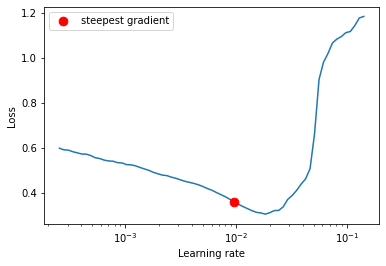

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.009545484566618342
EPOCH NUMERO: 13


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 0.32138973
El valor RMSE es igual a 0.5669124577437205
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818, 0.13054176474658963, 0.12292418721260824, 0.12329256793262991, 0.5669124577437205]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


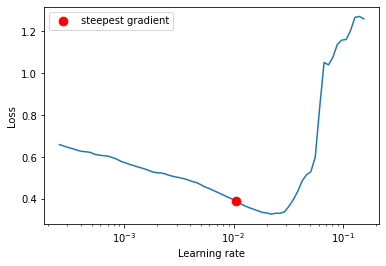

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.010476157527896652
EPOCH NUMERO: 14


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


  0%|          | 0/283 [00:00<?, ?it/s]

El valor del error cudratico medios (MSE) es igual a 77342.9
El valor RMSE es igual a 278.1059122663522
[0.1682918346727985, 0.4034999604337406, 0.37350473716392313, 0.22512576409728638, 0.1289963624006098, 2.6053401795196125, 0.21215405915562371, 50.486425407139144, 0.12967827114910818, 0.13054176474658963, 0.12292418721260824, 0.12329256793262991, 0.5669124577437205, 278.1059122663522]


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-03


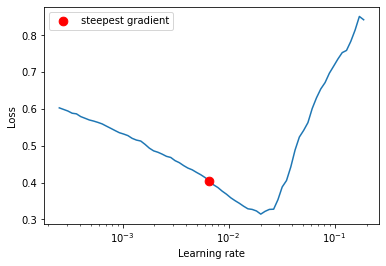

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MultiImage       | 12.8 M
1 | loss_function | MSELoss          | 0     
2 | train_mse     | MeanSquaredError | 0     
3 | valid_mse     | MeanSquaredError | 0     
---------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.8 M    Total params
51.102    Total estimated model params size (MB)


0.006579332246575679
EPOCH NUMERO: 15


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f7cda938050>
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c50ac0440>
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/use

  0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f7cda938050>
Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---


Traceback (most recent call last):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_102596/4046040387.py", line 107, in <module>
    for x, y in tqdm.notebook.tqdm(test_loader):
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/tqdm/notebook.py", line 257, in __iter__
    for obj in super(tqdm_notebook, self).__iter__():
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/tqdm/std.py", line 1180, in __iter__
    for obj in iterable:
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/users/hodei.zia/anaconda3/envs/ImitAI/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1182, in _next_data
    idx, data = self._get_data()
  File "/users/hodei.zia/anac

In [ ]:
Epoch_List = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for eps in Epoch_List:
    
    # 1 - Se genera la red
    
    # To pretrain
    model = models.resnet18(pretrained=True)

    # Get only the feature extractor (remove avgpool and fc layers)
    fe = nn.Sequential(*list(model.children())[:-2])

    fe.apply(freeze_all_but_bn) # Solo usar si no se preentrena la red

    # Create custom head
    head_clf = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(512*2+7, 1031), 
        nn.ReLU(),
        nn.BatchNorm1d(512*2+7), 
        nn.Dropout(0.25),
        nn.Linear(512*2+7, 512), 
        nn.ReLU(),
        nn.BatchNorm1d(512),   
        nn.Dropout(0.25),
        nn.Linear(512, 7)
    )

    # Rebuild the model
    model = MultiImage(fe, head_clf)
    
    # 2 - Se busca el mejor Learning Rate a aplicar como maximo posible
    
    # Loss function
    criterion = nn.MSELoss()

    # We catch the optimizer of our lit_model
    # optimizer, lr_scheduler = pl_model.configure_optimizers()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning State Finder
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

    # Create trainer class
    try:
        BEST_LR = lr_finder.plot()[1]
    except:
        BEST_LR = 5.0E-03
    print(BEST_LR)
    
    if BEST_LR > 0.09:
        BEST_LR = 5.0E-03

    # 3 - Se prepara el Trainer y se entrena con el modelo LitModel
    
    # Number of iterations for LR Schedule
    ITERATIONS_PER_EPOCH = len(train_loader)
    
    #logger = TensorBoardLogger("/home/hodei.zia/ImitAI Project/tb_logs", name="my_model")

    # Create PytorchLighting model for training
    pl_model = LitModel(model, criterion, total_iterations=ITERATIONS_PER_EPOCH * eps, lr=BEST_LR)

    NUM_GPUS = 1 if torch.cuda.is_available() else 0
    
    # Create trainer class
    #trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         #log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")], logger=logger)
    trainer = pl.Trainer(auto_lr_find=True, min_epochs=eps, max_epochs=eps,
                         log_every_n_steps=1, gpus=NUM_GPUS, callbacks=[CallbackClass(what="epochs")])

    print("EPOCH NUMERO: " + str(eps))
    
    # Train the model
    trainer.fit(pl_model, train_loader, val_dataloaders=test_loader)
    
    ## TODO 
    '''
    errores=[]
    path_to_events_file="/home/juan.uriarte/ImitAI Project/tb_logs/my_model_wrist/version_0/events.out.tfevents.1648647670.gpu02.net.unavarra.es.271889.0"
    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            if v.tag == 'training_loss_epoch':
                errores.append(v.simple_value)plt.plot(errores, label='loss')
    plt.title("Loss por epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    
    # 4 - Se predice el resultado
    
    # Put model on eval mode so we change the BatchNorm and Dropout layers behaviour
    model = model.eval()
    # Set device ("cuda" or GPU if cuda is installed, otherwise in "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # To concatenate predictions and labels
    predictions = None
    labels = None
    # Surround all for not computing gradients
    with torch.no_grad():
        # Iterate over test dataset
        for x, y in tqdm.notebook.tqdm(test_loader):
            # Move to device
            x1, x2, x3 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            # Predict
            o = model((x1, x2, x3))
            # Concatenate
            if predictions is None:
                predictions = o
            else:
                predictions = torch.cat((predictions, o), axis=0)

            if labels is None:
                labels = y
            else:
                labels = torch.cat((labels, y), axis=0)

        # Move predictions to CPU and to numpy
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    rmse = sqrt(mse)
    
    print("El valor del error cudratico medios (MSE) es igual a " + str(mse))
    print("El valor RMSE es igual a " + str(rmse))

    # 5 - Se guardan los resultados 
    
    RMSE_List.append(rmse)
    Model_List.append(model)
    Prediction_List.append(predictions)
    Label_List.append(labels)
    LR_List.append(BEST_LR)
    #Loss_List.append(lr_finder.history['loss'][lr_finder.history['lr'].index(BEST_LR)])
    
    print(RMSE_List)

BEST RMSE: 0.3954983557053251 in Epoch 7 with Batch Size = 32 
LR = 0.009545484566618342


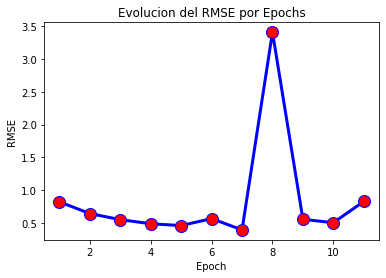

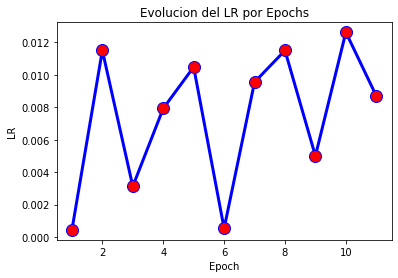

In [243]:
Epoch_List = [1,2,3,4,5,6,7,8,9,10,11,12]

print("BEST RMSE: " + str(min(RMSE_List)) + " in Epoch " + 
      str(RMSE_List.index(min(RMSE_List)) + 1) + " with Batch Size = " + str(BATCH_SIZE) + " \nLR = " + 
      str(LR_List[(RMSE_List.index(min(RMSE_List)))]))

# Plot de RMSE-Epoch
plt.plot(Epoch_List[:-1], RMSE_List[:-1], color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE por Epochs')
plt.show()

# Plot del LR-Epoch
plt.plot(Epoch_List[:-1], LR_List[:-1], color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=12)
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Evolucion del LR por Epochs')
plt.show()

0.3954983557053251
[0.68440205 0.37229876 0.62659915 0.1742014  0.23347002 0.04405965
 0.0921865 ]
Articulacion 0 [-1.0 - 1.0] 2.0 34.22%
Articulacion 1 [-1.0 - 1.0] 2.0 18.61%
Articulacion 2 [-1.0 - 1.0] 2.0 31.33%
Articulacion 3 [-1.0 - 1.0] 2.0 8.71%
Articulacion 4 [-1.0 - 1.0] 2.0 11.67%
Articulacion 5 [-1.0 - 1.0] 2.0 2.2%
Articulacion 6 [-1.0 - 1.0] 2.0 4.61%


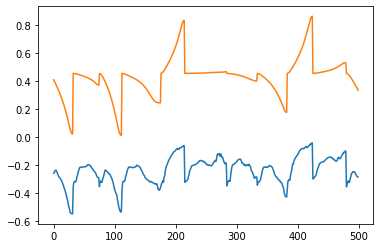

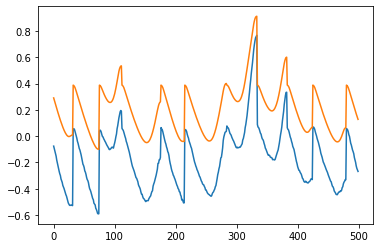

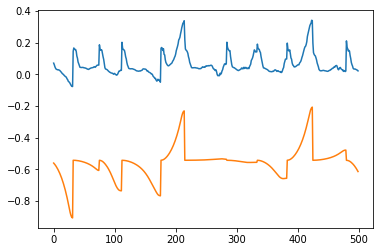

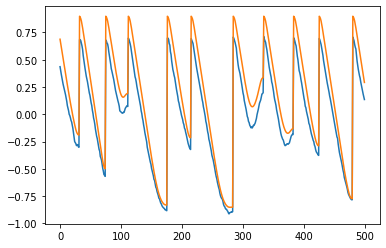

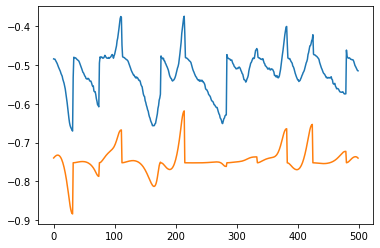

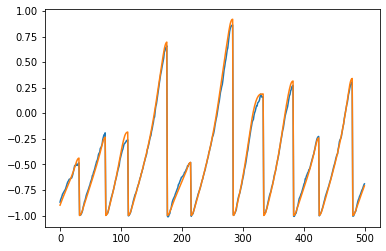

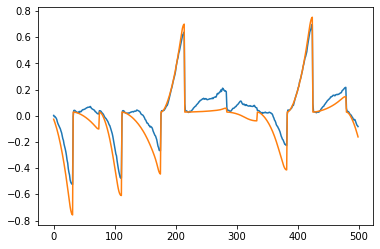

In [242]:
print(RMSE_List[RMSE_List.index(min(RMSE_List))])

labels = Label_List[(RMSE_List.index(min(RMSE_List)))]
predictions = Prediction_List[(RMSE_List.index(min(RMSE_List)))]

# Error promedio de cada una de las articulaciones
joint_error = np.zeros(7)
minimo = np.zeros(7)
maximo = np.zeros(7)
for i in range(7):
    joint_error[i] = sqrt(sklearn.metrics.mean_squared_error(predictions[:, i], labels[:, i]))
    minimo[i] = min(labels[:, i])
    maximo[i] = max(labels[:, i])
    
print(joint_error)

for i in range(7):
    print("Articulacion " + str(i) + " [" + str(round(minimo[i], 2)) + " - " + str(round(maximo[i], 2)) + "] " +
          str(round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2))
          , str(round(joint_error[i]*100/round(abs(round(minimo[i], 2) - round(maximo[i], 2)),2),2)) + "%")
    
    
for i in range(7):
    plt.plot(predictions[500:1000, i], label='prediction')
    plt.plot(labels[500:1000, i], label='target')
    plt.show()

## Print the Results

In [ ]:
print(os.getcwd())
observaciones=fnmatch.filter(os.listdir('Test_dataset'), '*.csv')

ordenado=[]
for i in observaciones:
    if i.split(".")[0].split("_")[1]!="Actions":
        ordenado.append(int(i.split(".")[0].split("_")[1]))
ordenado=sorted(ordenado)
        
tamPruebas=[0]
j=0
for observacion in ordenado:
    observacion="0_"+str(observacion)+".csv"
    tam=len(pd.read_csv("Test_dataset/"+str(observacion)))
    j+=tam
    tamPruebas.append(j)
    
print(tamPruebas)

In [ ]:
#MSE por demostracion
mseDem=[]
rmseDem=[]
for j in range(len(tamPruebas)-1):
    mseDem.append(sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    rmseDem.append(sqrt(mseDem[i]))
print("Los valores del error cudratico medios (MSE) por demostracion son igual a "+str(mseDem[0:5]))
print("Los valores RMSE por demostracion son igual a "+str(rmseDem[0:5]))
print("El valor maximo de MSE es "+str(max(mseDem))+" y equivale a la prueba "+str(np.argmax(mseDem)))
print("El valor medio de MSE es "+str(np.mean(mseDem)))

In [ ]:
import matplotlib.pyplot as plt
# Ploteo las comparaciones de las predicciones con los labels
#for j in range(len(tamPruebas)-1):
for j in range(3):
    print("MSE:",sklearn.metrics.mean_squared_error(labels[tamPruebas[j]:tamPruebas[j+1]], predictions[tamPruebas[j]:tamPruebas[j+1]]))
    for i in range(7):
        plt.plot(predictions[tamPruebas[j]:tamPruebas[j+1], i], label='prediction')
        plt.plot(labels[tamPruebas[j]:tamPruebas[j+1], i], label='target')
        plt.title("Observacion: " + str(j+1) +" - Articulacion " + str(i+1))
        plt.show()

## Save the Model

In [173]:
print(Model_List[(RMSE_List.index(min(RMSE_List)) + 1)])
torch.save(Model_List[(RMSE_List.index(min(RMSE_List)) + 1)], 'model_pytorch_00910--')
model = torch.load('model_pytorch_00910--')
model.eval()

MultiImage(
  (fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

MultiImage(
  (fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 